In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
import shap

def preprocess_data(df):
    label_encoder = LabelEncoder()
    df['district_encoded'] = label_encoder.fit_transform(df['district'])

    binary_questions = ['breast_q1', 'breast_q2', 'breast_q3', 'breast_q4',	'breast_q5', 'liver_q1', 'liver_q2', 'liver_q3', 'liver_q4', 'liver_q5']
    
    df = df.replace(to_replace = ['Yes', 'No'], value = [1, 0])
    
    df['breast_score'] = df[binary_questions[0:5]].sum(axis=1)
    df['liver_score'] = df[binary_questions[5:]].sum(axis=1)

    
    # Handle height inconsistencies
    df.loc[df['height'] == 160000, 'height'] = 160
    df.loc[df['height'] == 1.55, 'height'] = 155
    df.loc[df['height'] == 1.58, 'height'] = 158
    df.loc[df['height'] == 60, 'height'] = 160
    
    df = df[(df['weight'] < 158) & (df['weight'] > 23)]
    df = df[(df['sleep_hr'] < 40) & (df['sleep_hr'] > 2)]
    df['bmi'] = df['weight']/(df['height']/100)**2

    replacements = {
    'A year ago': 0,
    '6 months ago': 1,
    'Female': 0,
    'Male': 1,
    'Not sure': 0
    }
    
    # Replace all values in one line
    df = df.replace(replacements)
    
    # Handle outliers using IQR
    # def remove_outliers(df, column):
    #     Q1 = df[column].quantile(0.25)
    #     Q3 = df[column].quantile(0.75)
    #     IQR = Q3 - Q1
    #     return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]
    
    # numerical_cols = ['weight', 'height', 'sleep_hr', 'fam_hr', 'neighbor_hr', 'age', 'red_meat_weekly', 'veg_weekly', 'alc_weekly', 'exercise_weekly']
    # for col in numerical_cols:
    #     df = remove_outliers(df, col)
    
    df = df.drop(columns = binary_questions + ['district', 'chronic_dis_list', 'weight', 'height','have_children'], axis = 1)
    
    return df

# Prepare the data
df = pd.read_csv("cancer_dataset.csv")
df = preprocess_data(df)
print(df)

     last_cancer_screening  current_cancer  gender  age  red_meat_weekly  \
0                        0               0       0   30                2   
1                        0               0       1   40                3   
2                        0               0       0   31                3   
3                        0               0       1   30                4   
4                        0               0       1   40                3   
..                     ...             ...     ...  ...              ...   
178                      0               0       0   46                2   
179                      0               0       0   40                4   
180                      0               0       1   65                1   
181                      1               0       0   55                2   
182                      0               0       1   54                4   

     veg_weekly  alc_weekly  exercise_weekly  sleep_hr  fam_hr  neighbor_hr  \
0       

/var/folders/td/cp8pk7qn70s163f4fndy1jt40000gn/T/ipykernel_46599/4250039077.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(to_replace = ['Yes', 'No'], value = [1, 0])
/var/folders/td/cp8pk7qn70s163f4fndy1jt40000gn/T/ipykernel_46599/4250039077.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(replacements)


## 2. Find the best sampling strategy using SMOTENC

In [34]:
def sample_strategy(X, y, categorical_features, cv_splits=5, strategy=None):
    continuous_features = [i for i in range(X.shape[1]) if i not in categorical_features]
    X_continuous = X.iloc[:, continuous_features]
    X_categorical = X.iloc[:, categorical_features]

    # Scale continuous features
    scaler = StandardScaler()
    X_continuous_scaled = scaler.fit_transform(X_continuous)
    X_scaled = np.hstack([X_continuous_scaled, X_categorical])

    smote = SMOTENC(
        categorical_features=categorical_features,
        sampling_strategy={0: strategy, 1: strategy},
        random_state=42
    )
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    fold_metrics = {
        'accuracy': [],
        'roc_auc': [],
        'precision': [],
        'recall': [],
        'train_accuracy': [],
        'train_roc_auc': [],
        'train_precision': [],
        'train_recall': [],
    }
    y_test_all, y_pred_all = [], []
    
    for train_idx, val_idx in skf.split(X_resampled, y_resampled):
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            oob_score=True,
            random_state=42,
            class_weight='balanced'
        )
        rf.fit(X_train, y_train)
        
        # Predictions
        y_pred = rf.predict(X_val)
        y_pred_prob = rf.predict_proba(X_val)[:, 1]
        
        # Store predictions
        y_test_all.append(y_val)
        y_pred_all.append(y_pred)
        
        # Validation metrics
        fold_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        fold_metrics['roc_auc'].append(roc_auc_score(y_val, y_pred_prob))
        fold_metrics['precision'].append(precision_score(y_val, y_pred))
        fold_metrics['recall'].append(recall_score(y_val, y_pred))

        # Training metrics
        y_train_pred = rf.predict(X_train)
        y_train_pred_prob = rf.predict_proba(X_train)[:, 1]
        
        fold_metrics['train_accuracy'].append(accuracy_score(y_train, y_train_pred))
        fold_metrics['train_roc_auc'].append(roc_auc_score(y_train, y_train_pred_prob))
        fold_metrics['train_precision'].append(precision_score(y_train, y_train_pred))
        fold_metrics['train_recall'].append(recall_score(y_train, y_train_pred))
    
    metrics = {
        'avg_accuracy': np.mean(fold_metrics['accuracy']),
        'avg_roc_auc': np.mean(fold_metrics['roc_auc']),
        'avg_precision': np.mean(fold_metrics['precision']),
        'avg_recall': np.mean(fold_metrics['recall']),
        'avg_train_accuracy': np.mean(fold_metrics['train_accuracy']),
        'avg_train_roc_auc': np.mean(fold_metrics['train_roc_auc']),
        'avg_train_precision': np.mean(fold_metrics['train_precision']),
        'avg_train_recall': np.mean(fold_metrics['train_recall']),
    }

    return metrics

def best_strategy(X, y, categorical_features, cv_splits=5, strategy_range=None):
    results = []
    for strategy in strategy_range:
        result = sample_strategy(X, y, categorical_features, cv_splits=cv_splits, strategy=strategy)
        result['strategy'] = strategy
        results.append(result)
    return results

In [36]:
features = ['age', 'gender', 'bmi', 
            'cancer_his', 'have_cancer_before', 
            'red_meat_weekly', 'alc_weekly', 'exercise_weekly', 
            'sleep_hr', 'fam_hr']
# X = df.drop(columns=['current_cancer', 'breast_score', 'liver_score'], axis=1)
X = df[features]
y = df['current_cancer']
# categorical_features = [0, 1, 10, 11, 12, 13]
categorical_features = [1, 3, 4]

strategy_range = range(100, 300, 50)

results = best_strategy(X, y, categorical_features, cv_splits=5, strategy_range=strategy_range)

# Print results
for result in results:
    print(f"Strategy: {result['strategy']}")
    print(f"  Validation Accuracy: {result['avg_accuracy']:.3f}")
    print(f"  Validation ROC-AUC: {result['avg_roc_auc']:.3f}")
    print(f"  Validation Precision: {result['avg_precision']:.3f}")
    print(f"  Validation Recall: {result['avg_recall']:.3f}")
    print(f"  Training Accuracy: {result['avg_train_accuracy']:.3f}")
    print(f"  Training ROC-AUC: {result['avg_train_roc_auc']:.3f}")
    print(f"  Training Precision: {result['avg_train_precision']:.3f}")
    print(f"  Training Recall: {result['avg_train_recall']:.3f}\n")

Strategy: 100
  Validation Accuracy: 0.945
  Validation ROC-AUC: 0.984
  Validation Precision: 0.943
  Validation Recall: 0.950
  Training Accuracy: 0.983
  Training ROC-AUC: 0.999
  Training Precision: 0.990
  Training Recall: 0.975

Strategy: 150
  Validation Accuracy: 0.947
  Validation ROC-AUC: 0.991
  Validation Precision: 0.949
  Validation Recall: 0.947
  Training Accuracy: 0.988
  Training ROC-AUC: 1.000
  Training Precision: 0.997
  Training Recall: 0.980

Strategy: 200
  Validation Accuracy: 0.968
  Validation ROC-AUC: 0.995
  Validation Precision: 0.966
  Validation Recall: 0.970
  Training Accuracy: 0.987
  Training ROC-AUC: 1.000
  Training Precision: 0.992
  Training Recall: 0.981

Strategy: 250
  Validation Accuracy: 0.978
  Validation ROC-AUC: 0.997
  Validation Precision: 0.980
  Validation Recall: 0.976
  Training Accuracy: 0.993
  Training ROC-AUC: 1.000
  Training Precision: 0.998
  Training Recall: 0.988



## 3. Train the model with sampling strategy of 150 and evaluation

In [38]:
def train_evaluate_model(X, y, categorical_features, strategy, cv_splits=5):
    # Separate continuous and categorical features
    continuous_features = [i for i in range(X.shape[1]) if i not in categorical_features]
    X_continuous = X.iloc[:, continuous_features]
    X_categorical = X.iloc[:, categorical_features]

    # Scale continuous features
    scaler = StandardScaler()
    X_continuous_scaled = scaler.fit_transform(X_continuous)
    X_scaled = np.hstack([X_continuous_scaled, X_categorical])

    # Apply SMOTENC
    smote = SMOTENC(
        categorical_features=categorical_features,
        sampling_strategy = {0: strategy, 1: strategy},
        random_state=42
    )
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    fold_metrics = {
        'accuracy': [],
        'roc_auc': [],
    }
    feature_importance = np.zeros(X_resampled.shape[1])
    y_test_all, y_pred_all, y_pred_proba_all = [], [], []
    
    for train_idx, val_idx in skf.split(X_resampled, y_resampled):
        # Split the data into training and validation for the current fold
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Train the Random Forest model
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            oob_score=True,
            random_state=42,
            class_weight='balanced'
        )
        rf.fit(X_train, y_train)
        
        # Evaluate the model on the validation set
        y_pred = rf.predict(X_val)
        y_pred_prob = rf.predict_proba(X_val)[:, 1]
        
        # Store predictions for the last fold (for visualization)
        y_test_all.append(y_val)
        y_pred_all.append(y_pred)
        y_pred_proba_all.append(y_pred_prob)
        
        # Calculate metrics
        acc = accuracy_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        
        # Store metrics
        fold_metrics['accuracy'].append(acc)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Accumulate feature importance
        feature_importance += rf.feature_importances_
    
    # Aggregate metrics across all folds
    avg_accuracy = np.mean(fold_metrics['accuracy'])
    avg_roc_auc = np.mean(fold_metrics['roc_auc'])
    feature_importance /= cv_splits
    
    # Use the last fold for visualization
    y_test_all = np.concatenate(y_test_all)
    y_pred_all = np.concatenate(y_pred_all)
    y_pred_proba_all = np.concatenate(y_pred_proba_all)
    
    # Print Metrics
    print(f"Cross-validation ROC-AUC Score: {avg_roc_auc:.3f}")
    print(f"Cross-validation Accuracy: {avg_accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test_all, y_pred_all))
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Confusion Matrix
    plt.subplot(131)
    cm = confusion_matrix(y_test_all, y_pred_all)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Plot 2: ROC Curve
    plt.subplot(132)
    fpr, tpr, _ = roc_curve(y_test_all, y_pred_proba_all)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {avg_roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # Plot 3: Feature Importance
    plt.subplot(133)
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importance
    })
    importance_df = importance_df.sort_values('importance', ascending=True)
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    
    plt.tight_layout()
    plt.show()
    
    return rf, avg_accuracy, avg_roc_auc, feature_importance

Cross-validation ROC-AUC Score: 0.983
Cross-validation Accuracy: 0.935

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       100
           1       0.95      0.92      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



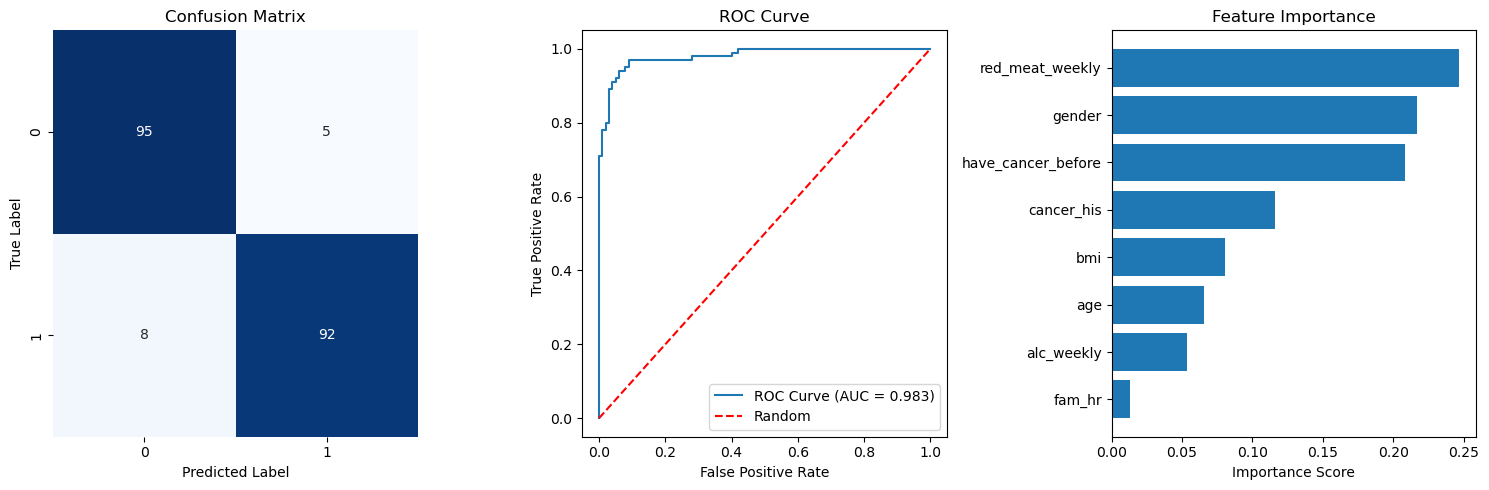

In [267]:
features = ['age', 'gender', 'bmi', 
            'cancer_his', 'have_cancer_before', 
            'red_meat_weekly', 'alc_weekly', 'fam_hr']
# X = df.drop(columns=['current_cancer', 'breast_score', 'liver_score'], axis=1)
X = df[features]
y = df['current_cancer']
# categorical_features = [0, 1, 10, 11, 12, 13]
categorical_features = [1]

# Train and evaluate
model, avg_accuracy, avg_roc_auc, feature_importance = train_evaluate_model(X, y, categorical_features, 100)

In [281]:
def get_risk_assessment(model, X, feature_names):
    # Get probability scores
    probs = model.predict_proba(X)
    
    # Calculate risk scores (0-100)
    risk_scores = probs[:, 1] * 100
    
    # Calculate confidence (distance from decision boundary)
    confidence = np.abs(probs[:, 1] - 0.5) * 2 * 100
    
    # Adjust risk scores by confidence
    adjusted_risk_scores = risk_scores * (confidence / 100)
    
    results = pd.DataFrame({
        'Risk Score': risk_scores,
        'Confidence': confidence,
        'Adjusted Risk Score': adjusted_risk_scores,
        'Risk Level': ['High Risk' if s >= 75 
                      else 'Medium Risk' if s >= 25 
                      else 'Low Risk' for s in adjusted_risk_scores]
    })
    
    return results

single_case = pd.DataFrame({
    'age': [22], 
    'gender': [1], 
    'bmi': [20], 
    'cancer_his': [1], 
    'have_cancer_before': [0], 
    'red_meat_weekly': [3], 
    'alc_weekly': [1], 
    'fam_hr': [40]
})

print("\nRisk Assessment for Single Case:")
print(get_risk_assessment(model, single_case, features))


Risk Assessment for Single Case:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 7 features, but RandomForestClassifier is expecting 8 features as input.

In [271]:
test_case_1 = pd.DataFrame({
    'age': [70],
    'gender': [1],
    'bmi': [30],
    'cancer_his': [1],
    'have_cancer_before': [1],
    'red_meat_weekly': [10],
    'alc_weekly': [5],
    'fam_hr': [20]
})
print("\nTest Case 1: High Age, Multiple Risk Factors")
print(get_risk_assessment(model, test_case_1, features))


Test Case 1: High Age, Multiple Risk Factors
   Risk Score  Confidence  Adjusted Risk Score Risk Level
0   70.645238   41.290476            29.169755   Low Risk


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [273]:
test_case_2 = pd.DataFrame({
    'age': [25],
    'gender': [0],
    'bmi': [20],
    'cancer_his': [0],
    'have_cancer_before': [0],
    'red_meat_weekly': [1],
    'alc_weekly': [0],
    'fam_hr': [10]
})
print("\nTest Case 2: Young Individual with Healthy Lifestyle")
print(get_risk_assessment(model, test_case_2, features))


Test Case 2: Young Individual with Healthy Lifestyle
   Risk Score  Confidence  Adjusted Risk Score Risk Level
0   64.107143   28.214286            18.087372   Low Risk


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [275]:
test_case_3 = pd.DataFrame({
    'age': [45],
    'gender': [1],
    'bmi': [25],
    'cancer_his': [0],
    'have_cancer_before': [0],
    'red_meat_weekly': [15],
    'alc_weekly': [7],
    'fam_hr': [5]
})
print("\nTest Case 3: Middle-Aged Individual with High Alcohol and Red Meat Consumption")
print(get_risk_assessment(model, test_case_3, features))


Test Case 3: Middle-Aged Individual with High Alcohol and Red Meat Consumption
   Risk Score  Confidence  Adjusted Risk Score Risk Level
0   39.961905    20.07619             8.022828   Low Risk


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [277]:
test_case_4 = pd.DataFrame({
    'age': [50],
    'gender': [0],
    'bmi': [23],
    'cancer_his': [1],
    'have_cancer_before': [0],
    'red_meat_weekly': [4],
    'alc_weekly': [1],
    'fam_hr': [50]
})
print("\nTest Case 4: Individual with Strong Family History of Cancer")
print(get_risk_assessment(model, test_case_4, features))


Test Case 4: Individual with Strong Family History of Cancer
   Risk Score  Confidence  Adjusted Risk Score Risk Level
0   67.616667   35.233333            23.823606   Low Risk


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [279]:
test_case_5 = pd.DataFrame({
    'age': [40],
    'gender': [1],
    'bmi': [24],
    'cancer_his': [0],
    'have_cancer_before': [0],
    'red_meat_weekly': [20],
    'alc_weekly': [0],
    'fam_hr': [10]
})
print("\nTest Case 5: Edge Case - Extremely High BMI and Red Meat Consumption")
print(get_risk_assessment(model, test_case_5, features))


Test Case 5: Edge Case - Extremely High BMI and Red Meat Consumption
   Risk Score  Confidence  Adjusted Risk Score Risk Level
0   43.935714   12.128571             5.328774   Low Risk


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
